In [10]:
# !pip install ucimlrepo

from ucimlrepo import fetch_ucirepo 
import sklearn.metrics
import math
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt


# fetch dataset 
wine = fetch_ucirepo(id=109) 
  
# data (as pandas dataframes) 
X = wine.data.features 
y = wine.data.targets 
  
# metadata 
# print(wine.metadata) 
  
# variable information 
wine.variables

,name,role,type,demographic,description,units,missing_values
0,class,Target,Categorical,None,None,None,no
1,Alcohol,Feature,Continuous,None,None,None,no
2,Malicacid,Feature,Continuous,None,None,None,no
3,Ash,Feature,Continuous,None,None,None,no
4,Alcalinity_of_ash,Feature,Continuous,None,None,None,no
5,Magnesium,Feature,Integer,None,None,None,no
6,Total_phenols,Feature,Continuous,None,None,None,no
7,Flavanoids,Feature,Continuous,None,None,None,no
8,Nonflavanoid_phenols,Feature,Continuous,None,None,None,no
9,Proanthocyanins,Feature,Continuous,None,None,None,no


In [108]:
features_used =  np.array([0,1])
use_all_features = True

classes_used = np.array([1,2])
use_all_classes = True

ninit = 20
addn = 1

X_used = X.to_numpy()
y_used = y.to_numpy().reshape(-1)

if not use_all_features:
    X_used = X.to_numpy()[ : , features_used]   

if not use_all_classes:
    mask = np.isin(y_used, classes_used)
    y_used = y_used[mask]
    X_used = X_used[mask]

Xpool, Xtest, ypool, ytest = train_test_split(
    X_used, y_used, 
    train_size=100, 
    stratify=y_used, 
    random_state=42  # optional for reproducibility
)

order=np.random.permutation(range(len(Xpool)))


In [109]:
def norm_grad_x(theta,x, C=1.):
    # probability of high class
    # if len(x) > 40:
    #   print(theta*x)
    
    p1 = 1/(1+np.exp(-np.sum(theta*x)))
      # probability of low class
    p0 = 1-p1
      # derivative of cost as derived above for high class
    dL1=-x/(1+np.exp(theta*x))+theta/C
      # same for low class
    dL0=x*np.exp(theta*x)/(1+np.exp(theta*x))+theta/C
      # 2-norm of these
    g1=np.sqrt(np.sum(dL1**2,1))
    g0=np.sqrt(np.sum(dL0**2,1))
      # averaged according to probabilities
    emc=p1*g1+p0*g0
    return emc

def norm_grad_softmax(theta, x, C=1.0):
    """
    Expected gradient norm for softmax cross-entropy loss.

    Args:
        theta: (K, D) weight matrix from LogisticRegression (multiclass)
        x: (N, D) input samples
        C: regularization parameter

    Returns:
        emc: (N,) array with expected gradient norm per sample
    """
    K, D = theta.shape
    N = x.shape[0]

    # Compute logits and softmax probabilities
    logits = x @ theta.T  # shape: (N, K)
    logits -= np.max(logits, axis=1, keepdims=True)  # for numerical stability
    exp_logits = np.exp(logits)
    probs = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)  # shape: (N, K)

    # Initialize EMC values
    emc = np.zeros(N)

    for k in range(K):
        # Assume true label is class k → one-hot y
        yk = np.zeros_like(probs)
        yk[:, k] = 1.0

        # Gradient: (p_k - y_k) * x
        diff = probs - yk  # shape: (N, K)
        grad = diff[:, :, np.newaxis] * x[:, np.newaxis, :]  # shape: (N, K, D)

        # Add L2 regularization gradient
        grad += theta[np.newaxis, :, :] / C  # broadcast to (N, K, D)

        # Compute 2-norm of the gradient per sample
        grad_norms = np.linalg.norm(grad, axis=(1, 2))  # shape: (N,)
        emc += probs[:, k] * grad_norms  # weighted by probability

    return emc


In [110]:
# reset training set and pool
testacc_emc=[]
trainset=order[:ninit]
Xtrain=np.take(Xpool,trainset,axis=0)
ytrain=np.take(ypool,trainset,axis=0)
poolidx=np.arange(len(Xpool),dtype=np.int64)
poolidx=np.setdiff1d(poolidx,trainset)

model = LogisticRegression(penalty='l2', C=1e1, solver='liblinear')

for i in range(math.ceil((len(Xpool) - ninit) / addn)):
    model.fit(Xtrain, ytrain)
    if not use_all_classes and len(classes_used) == 2:
        emc=norm_grad_x(model.coef_, Xpool[poolidx])
    elif use_all_classes:
        emc=norm_grad_softmax(model.coef_, Xpool[poolidx])
    else:
        raise ValueError
    
    ye=model.predict(Xtest)
    testacc_emc.append((len(Xtrain),sklearn.metrics.accuracy_score(ytest,ye)))

    ypool_p_sort_idx = np.argsort(emc)
    Xtrain=np.concatenate((Xtrain,Xpool[poolidx[ypool_p_sort_idx[-addn:]]]))
    ytrain=np.concatenate((ytrain,ypool[poolidx[ypool_p_sort_idx[-addn:]]]))
    poolidx=np.setdiff1d(poolidx,poolidx[ypool_p_sort_idx[-addn:]])
    # print('Model: LR, %i samples (EMC)'%(ninit+i*addn))
    
trainset=order[:ninit]
Xtrain=np.take(Xpool,trainset,axis=0)
ytrain=np.take(ypool,trainset,axis=0)
poolidx=np.arange(len(Xpool),dtype=np.int64)
poolidx=np.setdiff1d(poolidx,trainset)

testacc=[]
for i in range(math.ceil((len(Xpool) - ninit) / addn)):
    #TODO fit model
    #Hints below:
    #data:np.take(Xpool,order[:ninit+i*addn],axis=0)
    #labels: np.take(ypool,order[:ninit+i*addn],axis=0)
    data = np.take(Xpool, order[:ninit + i*addn], axis=0)
    labels = np.take(ypool, order[:ninit + i*addn], axis=0)
    model.fit(data, labels)
    #predict and calculate the accuracy
    y_pred = model.predict(Xtest)
    accuracy = np.sum(y_pred == ytest) / len(ytest)
    #calculate accuracy on test set
    testacc.append((ninit+i*addn, accuracy)) #add in the accuracy
    # print('Model: LR, %i random samples'%(ninit+i*addn))

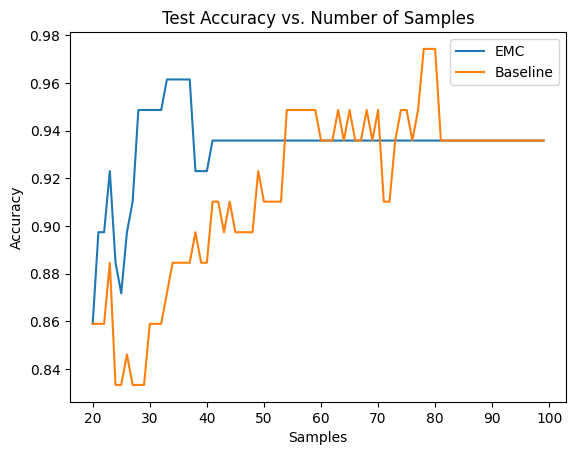

In [111]:
cut_at = 1000

plt.plot(*tuple(np.array(testacc_emc[:cut_at]).T), label='EMC')
plt.plot(*tuple(np.array(testacc[:cut_at]).T), label='Baseline')

plt.legend()  # Show the legend
plt.xlabel("Samples")
plt.ylabel("Accuracy")
plt.title("Test Accuracy vs. Number of Samples")
plt.show()